# **Property Rent Price Estimation**
Author: Waldy Setiono (waldysetiono@gmail.com)

**Background**: An online accomodation and space rental company based in South East Asia plans to expand its service area to Europe and the first city will be Paris. The company is now conducting research to determine the pricing strategy in order to compete with existing similar companies. There has been no standard method to determine how much a property owner should cost their customers so this company considers analyzing historical pricing data of one of its major competitors to predict its potential future service prices.

**Data**: The data used in this project is from [insideairbnb.com](http://insideairbnb.com/).

## **Outline**

[1. Cleaning and Exploratory Data Analysis](##**Cleaning-and-Exploratory-Data-Analysis**)

[2. Feature Engineering](##**Feature-Engineering**)

[3. Model Development and Evaluation](##**Model-Development-and-Evaluation)


## **Cleaning and Exploratory Data Analysis**

**Import packages and load data**

In [268]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [276]:
# Load and display the data
data = pd.read_csv("https://raw.githubusercontent.com/waldysetio/price-estimation/main/data/listings.csv")
data

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5396,https://www.airbnb.com/rooms/5396,20210909211521,2021-09-11,Explore the heart of old Paris,"Cozy, well-appointed and graciously designed s...","You are within walking distance to the Louvre,...",https://a0.muscache.com/pictures/52413/f9bf76f...,7903,https://www.airbnb.com/users/show/7903,Borzou,2009-02-14,"İstanbul, İstanbul, Turkey",The flat is owned by journalists who spend a l...,within an hour,100%,89%,f,https://a0.muscache.com/im/users/7903/profile_...,https://a0.muscache.com/im/users/7903/profile_...,Saint-Paul - Ile Saint-Louis,1.0,1.0,"['email', 'phone', 'facebook', 'google', 'revi...",t,t,"Paris, Ile-de-France, France",Hôtel-de-Ville,NaN,48.85247,2.35835,Entire rental unit,Entire home/apt,2,NaN,1 bath,NaN,1.0,"[""Hot water kettle"", ""Cooking basics"", ""Smoke ...",$110.00,2,1125,2,2,1125,1125,2.0,1125.0,NaN,t,0,3,29,29,2021-09-11,260,35,3,2013-09-22,2020-08-08,4.51,4.55,4.47,4.78,4.82,4.96,4.53,7510402838018,f,1,1,0,0,2.68
1,7397,https://www.airbnb.com/rooms/7397,20210909211521,2021-09-11,MARAIS - 2ROOMS APT - 2/4 PEOPLE,"VERY CONVENIENT, WITH THE BEST LOCATION !<br /...",NaN,https://a0.muscache.com/pictures/67928287/330b...,2626,https://www.airbnb.com/users/show/2626,Franck,2008-08-30,"Paris, Île-de-France, France","I am a writer,51, author of novels, books of l...",within an hour,100%,80%,t,https://a0.muscache.com/im/pictures/user/58f00...,https://a0.muscache.com/im/pictures/user/58f00...,Le Marais,4.0,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,NaN,Hôtel-de-Ville,NaN,48.85909,2.35315,Entire rental unit,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Cooking basics"", ""Smoke alarm"", ""Iron"", ""Ove...",$100.00,10,130,10,10,130,130,10.0,130.0,NaN,t,0,0,20,257,2021-09-11,278,9,2,2011-08-11,2021-08-18,4.70,4.79,4.44,4.91,4.88,4.92,4.70,7510400829623,f,1,1,0,0,2.26
2,7964,https://www.airbnb.com/rooms/7964,20210909211521,2021-09-11,Large & sunny flat with balcony !,Very large & nice apartment all for you! <br /...,NaN,https://a0.muscache.com/pictures/4471349/6fb3d...,22155,https://www.airbnb.com/users/show/22155,Anaïs,2009-06-18,"Paris, Île-de-France, France",Hello ! \r\nOur apartment is great and I am su...,within a day,60%,0%,f,https://a0.muscache.com/im/users/22155/profile...,https://a0.muscache.com/im/users/22155/profile...,Gare du Nord - Gare de I'Est,0.0,0.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,NaN,Opéra,NaN,48.87417,2.34245,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Essentials"", ""TV with standard cable"", ""Wifi...",$130.00,6,365,6,6,365,365,6.0,365.0,NaN,t,13,43,73,348,2021-09-11,6,0,0,2014-09-11,2015-09-14,4.80,5.00,5.00,5.00,5.00,5.00,5.00,7510903576564,f,1,1,0,0

**Check boolean and numerical categories**

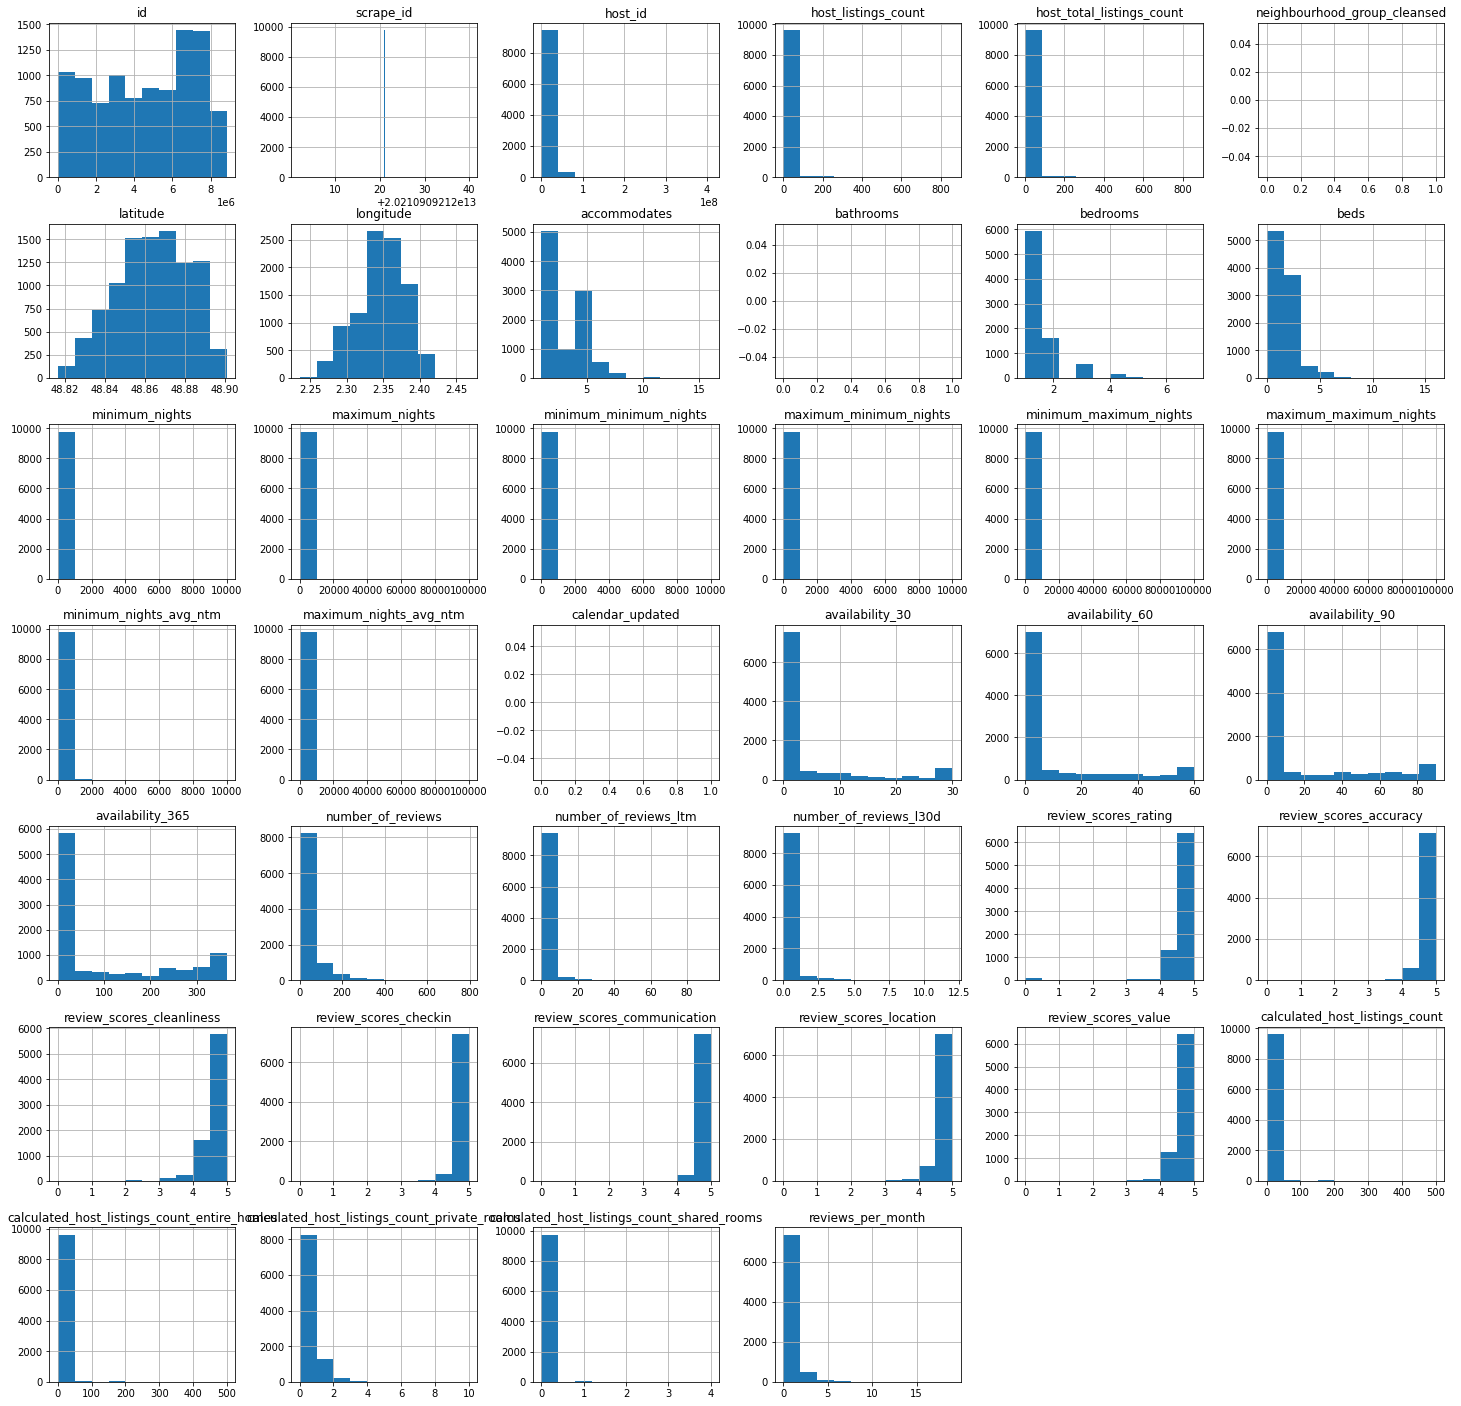

In [273]:
# Plotting the distribution of numerical and boolean categories
data.hist(figsize=(25,25));

**Drop unrelated columns**

This project is not going to implement sentiment analysis or text processing to make a predictive model, maybe in the future. Hence, for now columns containing reviews, summary, rules, and so on will be dropped. Other columns that might not be related to price or has just single unique value will be eliminated as well.

In [277]:
# Drop unused columns 
data = data.drop(["listing_url", "scrape_id", "last_scraped", "name", 
           "description", "neighborhood_overview", "picture_url", "host_id", 
           "host_url", "host_name", "host_location", "host_about", "host_thumbnail_url",
           "host_picture_url", "host_thumbnail_url", "host_picture_url", "host_verifications",
           "calendar_last_scraped", "number_of_reviews", "number_of_reviews_ltm",
           "first_review", "last_review", "license", "reviews_per_month", "host_neighbourhood",
           "host_listings_count", "host_has_profile_pic",
           "host_acceptance_rate", "host_is_superhost", "host_total_listings_count", 
           "host_identity_verified", "neighbourhood", 
           "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", 
           "maximum_maximum_nights", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", 
           "amenities", "has_availability", "availability_30", "availability_60", 
           "availability_90", "availability_365", "calculated_host_listings_count",
           "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms",
           "calculated_host_listings_count_shared_rooms"
           ], axis=1)

**Missing values**

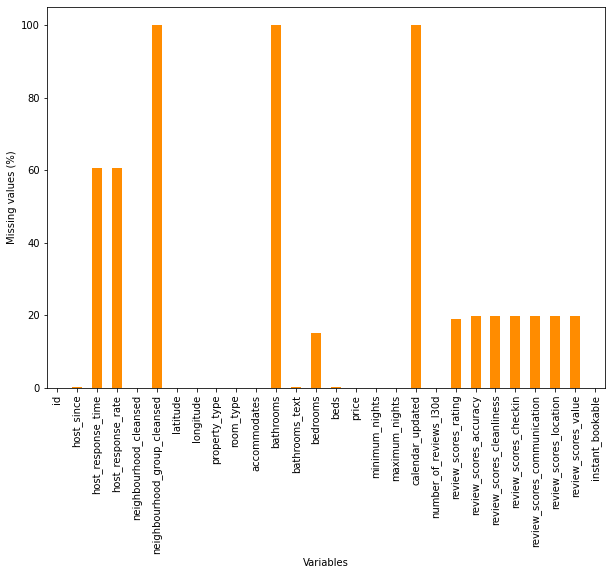

In [278]:
# Calculate missing values
missing_data_pecentage = data.isna().sum()/len(data.index)*100

# Plot missing values
missing_data_pecentage.plot(kind="bar", color="darkorange", figsize=(10,7))
plt.xlabel("Variables")
plt.ylabel("Missing values (%)")
plt.show()

We are going to drop columns with significant missing values. Row(s) in the "id" column that contains NaN will also be dropped because we can't subtitute data in "id" column with alternative data such as median, mean, mode, or else.

In [262]:
# Drop columns with significant missing data
data = data.drop(["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", 
                  "review_scores_checkin", "review_scores_communication", "calendar_updated",
                  "review_scores_location", "review_scores_value", "neighbourhood_group_cleansed"], 
                  "host_response_time", "host_response_rate", 
                  axis=1)

In [253]:
# Find row in which "id" that contains NaN value(s)
data[data["id"].isnull()]

,id,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews_l30d,instant_bookable


It seems there is no missing values in "id" column.

**Check duplicates**

In [254]:
data[data.duplicated()]

,id,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews_l30d,instant_bookable


**Descriptive statistics**

In [263]:
# Print basic statistics of the data
data.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews_l30d
count,9.773000e+03,9773.000000,9773.000000,9773.000000,0.0,8307.000000,9764.000000,9773.000000,9773.000000,9773.000000
mean,4.566605e+06,48.863963,2.347418,3.084519,NaN,1.399302,1.708316,152.778778,791.000205,0.224701
std,2.555640e+06,0.018012,0.032536,1.543349,NaN,0.728039,1.125500,202.618378,1115.873109,0.763510
min,5.396000e+03,48.816560,2.235490,1.000000,NaN,1.000000,0.000000,1.000000,1.000000,0.000000
25%,2.306018e+06,48.851160,2.328356,2.000000,NaN,1.000000,1.000000,3.000000,120.000000,0.000000
50%,4.756532e+06,48.865010,2.349990,2.000000,NaN,1.000000,1.000000,7.000000,1125.000000,0.000000
75%,6.912410e+06,48.878620,2.371830,4.000000,NaN,2.000000,2.000000,365.000000,1125.000000,0.000000
max,8.854802e+06,48.901120,2.467050,16.000000,NaN,7.000000,16.000000,9999.000000,99999.000000,12.000000


In [264]:
# Print the statistics including columns with object data type
data.describe(include=['object'])

,host_since,neighbourhood_cleansed,property_type,room_type,bathrooms_text,price,instant_bookable
count,9764,9773,9773,9773,9749,9773,9773
unique,1698,20,40,4,25,417,2
top,2013-07-22,Buttes-Montmartre,Entire rental unit,Entire home/apt,1 bath,$60.00,f
freq,78,1111,7799,8404,7725,462,8548


In [265]:
# Print data types of each column
data.dtypes

id                          int64
host_since                 object
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
property_type              object
room_type                  object
accommodates                int64
bathrooms                 float64
bathrooms_text             object
bedrooms                  float64
beds                      float64
price                      object
minimum_nights              int64
maximum_nights              int64
number_of_reviews_l30d      int64
instant_bookable           object
dtype: object

##**Feature Engineering**

**Create a dataframe of locations**

In [266]:
# Make a dataframe from longitude and latitude
long_lat = data[['longitude', 'latitude']]

**Inspect columns**

**host_since**

We will create a new feature called "active_days" by substracting the last_scraped date to host_since.

In [269]:
# Converting to datetime
data.host_since = pd.to_datetime(data.host_since) 

# Calculating the number of days
data['active_days'] = (datetime(2019, 4, 9) - data.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(data['active_days'].mean(),0))
print("Median days as host:", data['active_days'].median())

# Replacing null values with the median
data.active_days.fillna(data.active_days.median(), inplace=True)

Mean days as host: 1914.0
Median days as host: 1844.5


**property_type**

Let's change the data type of some columns that suit them better.

In [ ]:
# Function to change data type
def change_dtype(column_, datatype_):
    data[column_] = pd.to_numeric(data[column_], downcast=datatype_)

In [ ]:
# Convert columns data types
change_dtype("accommodates", "integer")
change_dtype("bathrooms", "integer")
change_dtype("bedrooms", "integer")
change_dtype("beds", "integer")
change_dtype("price", "float")
change_dtype("guests_included", "integer")
change_dtype("extra_people", "integer")
change_dtype("minimum_nights", "integer")
change_dtype("maximum_nights", "integer")
change_dtype("calculated_host_listings_count", "integer")
change_dtype("calculated_host_listings_count_entire_homes", "integer")
change_dtype("calculated_host_listings_count_private_rooms", "integer")
change_dtype("calculated_host_listings_count_shared_rooms", "integer")

In [ ]:
# Check unique values of each column
print(data.apply(lambda col: col.unique()))

id                                              [958, 5858, 7918, 8142, 8339, 8739, 10251, 105...
listing_url                                     [https://www.airbnb.com/rooms/958, https://www...
scrape_id                                                                        [20211006030728]
last_scraped                                                                         [2021-10-06]
name                                            [Bright, Modern Garden Unit - 1BR/1BTH, Creati...
                                                                      ...                        
calculated_host_listings_count                  [1, 9, 2, 29, 14, 4, 15, 13, 5, 17, 3, 22, 8, ...
calculated_host_listings_count_entire_homes     [1, 0, 2, 29, 14, 4, 13, 5, 17, 3, 22, 8, 10, ...
calculated_host_listings_count_private_rooms    [0, 9, 2, 1, 5, 3, 4, 6, 29, 54, 14, 15, 8, 32...
calculated_host_listings_count_shared_rooms                 [0, 13, 1, 17, 23, 26, 8, 5, 9, 3, 7]
reviews_per_month   

**Address remaining NaN values**

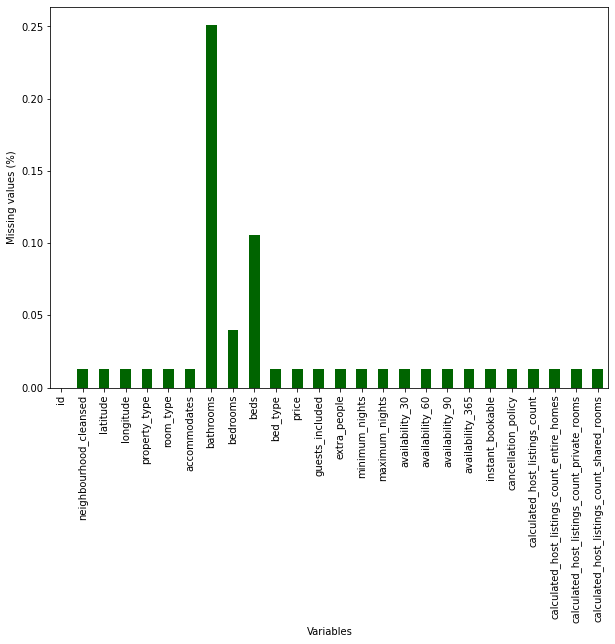

In [ ]:
# Count NaN values
missing_data_pecentage = data.isna().sum()/len(data.index)*100

# Plot NaN values
missing_data_pecentage.plot(kind="bar", color="darkgreen", figsize=(10,7))
plt.xlabel("Variables")
plt.ylabel("Missing values (%)")
plt.show()

In [ ]:
data.bathrooms.replace('nan', np.nan, inplace=True)

In [ ]:
# Replace NaN with mode
data["bathrooms"] = data["bathrooms"].fillna(data["bathrooms"].mode(), inplace=True)

In [ ]:
data["bathrooms"].unique()

array([None], dtype=object)

In [ ]:
data["bathrooms"]

0       None
1       None
2       None
3       None
4       None
        ... 
7571    None
7572    None
7573    None
7574    None
7575    None
Name: bathrooms, Length: 7575, dtype: object

In [ ]:
data["bathrooms"].mode()

Series([], dtype: object)

In [ ]:
data

,id,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,958.0,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3.0,None,1.0,2.0,Real Bed,170.0,2.0,25.0,1.0,30.0,1.0,3.0,7.0,92.0,True,moderate,1.0,1.0,0.0,0.0
1,5858.0,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5.0,None,2.0,3.0,Real Bed,235.0,2.0,0.0,30.0,60.0,0.0,0.0,0.0,0.0,False,strict_14_with_grace_period,1.0,1.0,0.0,0.0
2,7918.0,Haight Ashbury,37.76669,-122.45250,Apartment,Private room,2.0,None,1.0,1.0,Real Bed,65.0,1.0,12.0,32.0,60.0,30.0,60.0,90.0,365.0,False,strict_14_with_grace_period,9.0,0.0,9.0,0.0
3,8142.0,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2.0,None,1.0,1.0,Real Bed,65.0,1.0,12.0,32.0,90.0,11.0,41.0,71.0,346.0,False,strict_14_with_grace_period,9.0,0.0,9.0,0.0
4,8339.0,Western Addition,37.77525,-122.43637,House,Entire home/apt,5.0,None,2.0,2.0,Real Bed,685.0,2.0,150.0,4.0,1125.0,30.0,60.0,90.0,90.0,False,moderate,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7571,35284961.0,Noe Valley,37.75227,-122.42785,Condominium,Entire home/apt,2.0,None,2.0,2.0,Real Bed,475.0,1.0,0.0,3.0,1125.0,26.0,56.0,86.0,86.0,False,strict_14_with_grace_period,1.0,1.0,0.0,0.0
7572,35285751.0,Mission,37.75455,-122.42382,Apartment,Entire home/apt,3.0,None,1.0,1.0,Real Bed,115.0,1.0,0.0,30.0,150.0,23.0,53.0,83.0,173.0,False,flexible,92.0,91.0,1.0,0.0
7573,35286441.0,Mission,37.75803,-122.42080,House,Entire home/apt,6.0,None,2.0,2.0,Real Bed,500.0,4.0,25.0,1.0,10.0,7.0,9.0,9.0,9.0,True,moderate,2.0,1.0,1.0,0.0
7574,35288483.0,Outer Sunset,37.76089,-122.50258,House,Entire home/apt,6.0,None,2.0,3.0,Real Bed,180.0,4.0,5.0,30.0,1125.0,16.0,46.0,76.0,107.0,True,strict_14_with_grace_period,3.0,2.0,1.0,0.0


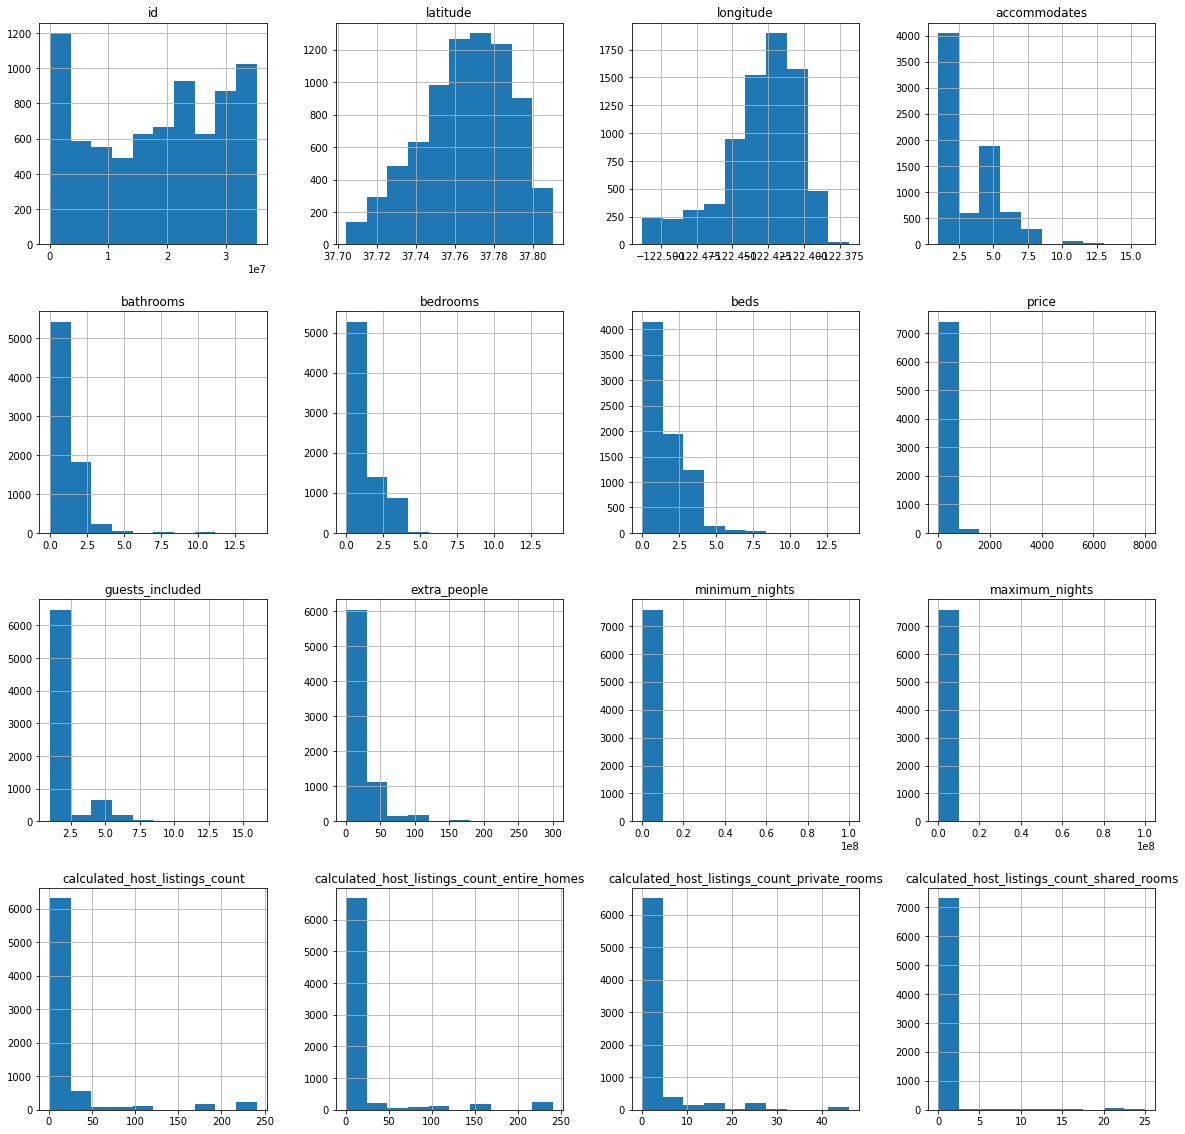

In [ ]:
data.hist(figsize=(20,20));

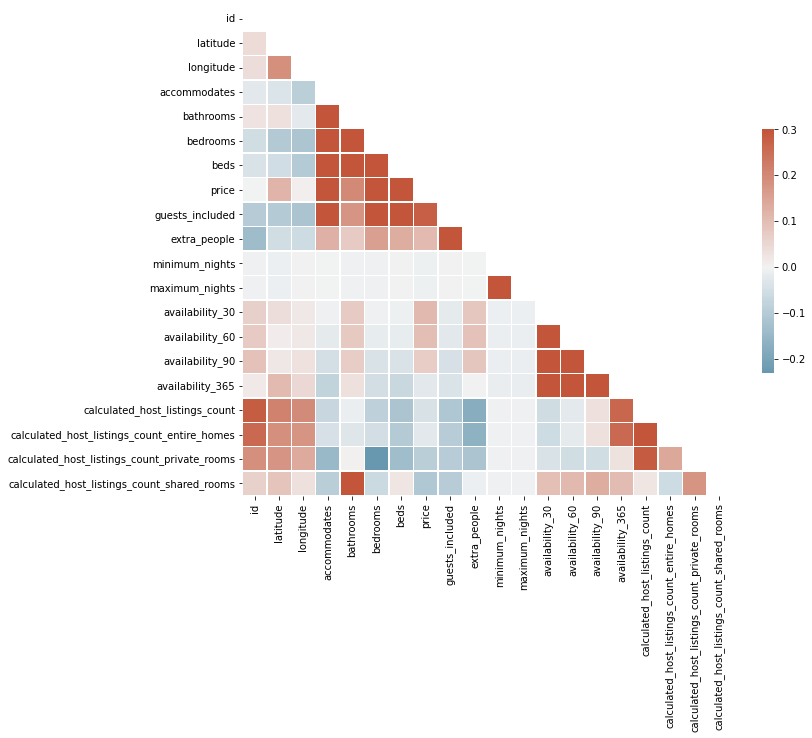

In [ ]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})